# EDA - Swire

Kyle Anderson

### Import Library

In [1]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import sqlalchemy

## Read in Data

In [2]:
iwc_data = fr"C:\Users\kyle.anderson\pythonProject\msbaCapstone\Capstone\Capstone 3\IWC_Work_Orders_Extract.csv"
original_df = pd.read_csv(iwc_data, low_memory=False)

# Cleaning

### Based on Distribution Keep Most Recent Data and Removed Dates Less Than 2018

In [3]:
original_df['START_YEAR_MONTH'] = pd.to_datetime(original_df['EXECUTION_START_DATE']).dt.strftime('%Y-%m')
original_df['YEAR'] = pd.to_datetime(original_df['EXECUTION_START_DATE']).dt.year

df = original_df[original_df['YEAR'] >= 2018].copy()

df.drop(columns=['YEAR'], inplace=True)

## Data Dictionary

In [4]:
data_dictionary = {
    "ORDER_ID": "An identifier used to uniquely map every order raised in IWC",
    "PLANT_ID": "Helps uniquely identify all factories of Swire Coca-Cola, between Monza, Cota, Silverstone, Monaco, Roma and Suzuka",
    "PRODUCTION_LOCATION": "Text description of Plant_ID",
    "EXECUTION_START_DATE": "The date on which work began on the said issue",
    "EXECUTION_FINISH_DATE": "The date on which work ended to resolve said issue",
    "ACTUAL_START_TIME": "The time at which work began on resolving said issue",
    "ACTUAL_FINISH_TIME": "The time at which work ended on resolving said issue",
    "ACTUAL_WORK_IN_MINUTES": "The time it took, in minutes, to resolve said issue",
    "MAINTENANCE_PLAN": "If the maintenance task was planned, this would have the plan ID. If this column is null, that implies that the maintenance was unplanned",
    "MAINTENANCE_ITEM": (
        "If the maintenance task was planned, for example, this bearing needs to be "
        "changed every six weeks, then the plan in the IWC system will have code "
        "allocated to it, saying this bearing code a maintenance will repeat at X "
        "interval and the serial number you see in this column maps to bearings "
        "(Mapping not provided for security reasons)"
    ),
    "MAINTENANCE_ACTIVITY_TYPE": "Lets you know if the maintenance was planned or unplanned, as an additional flag",
    "ORDER_DESCRIPTION": "The description entered by the mechanic as to what was the actual work that was carried out in said fix",
    "MAINTENANCE_TYPE_DESCRIPTION": "Tells you if the work order was preventive in nature, i.e. done to prevent breakdowns in future, or corrective in nature, i.e. done to correct something that caused a downtime",
    "FUNCTIONAL_LOC": (
        "Works like an IP address. Helps locate each machine by plant – process – sub "
        "process – product line – machine. Is broken down into nodes for better analysis"
    ),
    "FUNCTIONAL_AREA_NODE_1_MODIFIED": "The functional area within said plant – Production, fleet, HVAC, etc.",
    "FUNCTIONAL_AREA_NODE_2_MODIFIED": "The region-based subset of the functional area – Is it the blender room, the assembly lines – can, bottle or bibs",
    "FUNCTIONAL_AREA_NODE_3_MODIFIED": "Within each region, which subset of equipment does this work order belong to",
    "FUNCTIONAL_AREA_NODE_4_MODIFIED": "Within line groupings, which line is it specifically referring to – contains line number",
    "FUNCTIONAL_AREA_NODE_5_MODIFIED": "Further splits the line into individual machine types",
    "EQUIPMENT_ID": "Within a filler, there are close to 60 smaller components. This will help us identify which component the work was done on within that filler, for example",
    "EQUIPMENT_DESC5": "Helps us identify what that component is. Mind you, we won’t always have a description because some components are either too small to be classified or proprietary and hence undisclosed",
    "EQUIPMENT_CAT_DESC": "Identifies if the fixed part was on a machine, a vehicle, an HVAC system, etc.",
    "EQUIP_START_UP_DATE": "The date on which this machine was acquired",
    "EQUIP_VALID_FROM": "The date on which this machine became functional",
    "EQUIP_VALID_TO": "The date until which this machine shall be used"
}


### Set Datetime Data Type for Date Columns

In [5]:
date_columns = [col for col in df.columns if 'date' in col.lower()]
df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')

# Analysis Section

### Value Counts to Gauge What is Common and Uncommon

In [6]:
value_counts_filtered = {}

for column in df.columns:
    counts = df[column].value_counts()
    filtered_counts = counts[(counts >= 3) & (counts <= 20)]
    value_counts_filtered[column] = filtered_counts

In [7]:
# value_counts_filtered

#### Value Counts Findings

Running Value Counts with parameters between 3 and 20 is an effort to identify the uncommon items within each feature

* Execution start/end dates can vary widely depending on the amount of items needing attention. Most other time items are unique events and have low counts and would only occur once.
* For equipment pieces and locations, the counts are very high due to commmonality or size.

In [8]:
# Loop through each column to run .describe() based on data type
# Do this again by grouping by location and then do it by equipment
for col in df.columns:
    print(f"Feature: {col}")
    
    if 'date' in col.lower():
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(df[col].describe())  # Describe datetime features
    
    elif pd.api.types.is_numeric_dtype(df[col]):
        print(df[col].describe())
    
    elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
        print(df[col].describe())
    
    else:
        print(f"{col} has an unsupported data type for description.")
    
    print("\n" + "="*40 + "\n")

Feature: ORDER_ID
count    1.288033e+06
mean     4.505000e+10
std      8.289369e+10
min      1.000219e+08
25%      6.005952e+08
50%      7.046223e+08
75%      1.002330e+09
max      9.000001e+11
Name: ORDER_ID, dtype: float64


Feature: PLANT_ID
count     1288033
unique          6
top          G261
freq       550426
Name: PLANT_ID, dtype: object


Feature: PRODUCTION_LOCATION
count         1288033
unique              6
top       SILVERSTONE
freq           550426
Name: PRODUCTION_LOCATION, dtype: object


Feature: EXECUTION_START_DATE
count                          1288033
mean     2021-05-07 20:27:19.892145664
min                2018-01-01 00:00:00
25%                2019-08-10 00:00:00
50%                2021-04-29 00:00:00
75%                2023-02-11 00:00:00
max                2024-08-30 00:00:00
Name: EXECUTION_START_DATE, dtype: object


Feature: EXECUTION_FINISH_DATE
count                          1288033
mean     2021-05-08 13:28:19.410806784
min                2018-01-01 00:00

* Order ID - is the most unique and uninteresting
* Plant ID - 6 locations, Top is G261
* Production Location - 6 locations, Silverstone at the top
* Execution Start Date - Mean is 2020-12-20, it would be good to run a graph or median to see weights and maybe reduce for data cleaning
* Execution Finish Date - Mean is 2020-12-21, more stats needed
* Actual Start Time - Most frequent is 12 am...
* Actual Finish Time - Most frequent is 12 am...
* Actual Work In Minutes - tbd
* Maintenance Plan - tbd
* Maintenance Item - tbd
* Maintenance Activity Type - Unplanned most common, TARGET variable
* Order Description - Dtrine most common
* Maintenance Type Description - Preventive Maintenance Order most common
* Functional Loc - G812-PRD most common with 667 unique locations
* Functional Area Node 1 Modified - COTA Production most common, 7 unique and this is where I identified, whoever created this is a motorcycle racing fan
* Functional Area Node 2 Modified - CAN Line most common with 67 unique
* Functional Area Node 3 Modified - Line #4- Filler Rotary CAN most common, 141 unique
* Functional Area Node 4 Modified - Filler most common, 86 unique
* Functional Area Node 5 Modified - Full CAN to Accumulation Table most common, 36 unique
* Equipment Desc - L1 Filler Rotary CAN 72 Valve, 807 unique
* Equip Cat Desc - 4 unique, top Machines
* Equip Start Up Date - 2017-06-19 mean, more detail needed
* Equip Valid From - 137 unique, top is 2017-02-15
* Equip Valid To - 1 unique, assumption is all pieces last to the end of time?

### A Recommendation to Add a Real Life Cycle

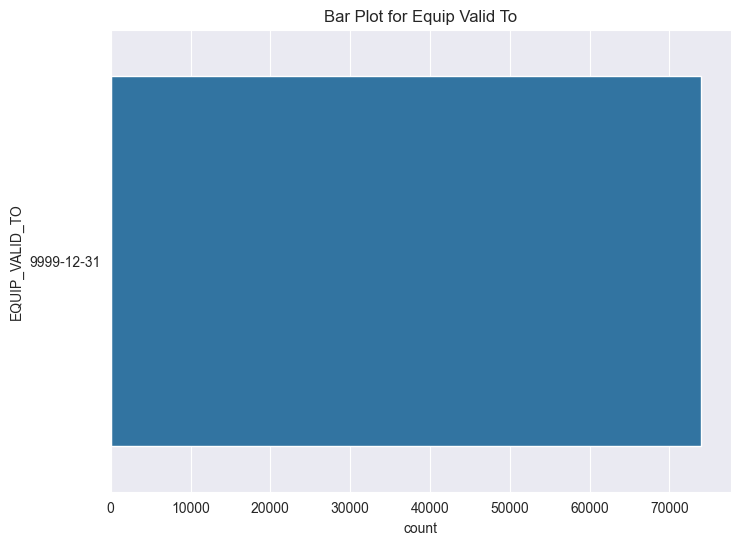

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(y=df['EQUIP_VALID_TO'], order=df['EQUIP_VALID_TO'].value_counts().index)
plt.title(f"Bar Plot for Equip Valid To")
plt.show()

## Investigate Startups by Month

In [10]:
df['EQUIP_START_UP_DATE'] = pd.to_datetime(df['EQUIP_START_UP_DATE'], errors='coerce')

df = df[df['EQUIP_START_UP_DATE'] >= '2018-01-01']
df['Start_year'] = df['EQUIP_START_UP_DATE'].dt.year
df['Start_year'] = df['Start_year'].astype(str)
df['Start_month'] = df['EQUIP_START_UP_DATE'].dt.month
df['Start_month'] = df['Start_month'].astype(str)

df['YYMM_starts'] = df['Start_year'] + " " + df['Start_month']
df['YYMM_starts'].info()

<class 'pandas.core.series.Series'>
Index: 20246 entries, 0 to 1385114
Series name: YYMM_starts
Non-Null Count  Dtype 
--------------  ----- 
20246 non-null  object
dtypes: object(1)
memory usage: 316.3+ KB


In [11]:
startups_per_year = df['YYMM_starts'].value_counts()
startups_per_year = startups_per_year.sort_index(ascending=True)
startups_per_year.tail(20)

YYMM_starts
2021 4       5
2021 8     153
2022 1      49
2022 10    328
2022 11    474
2022 2     317
2022 3      59
2022 4      24
2022 5      37
2022 6      10
2022 8      61
2022 9      30
2023 1      27
2023 11     15
2023 12    270
2023 4     394
2023 8      17
2023 9       2
2024 4     121
2024 5       2
Name: count, dtype: int64

### Startups by Month by Month

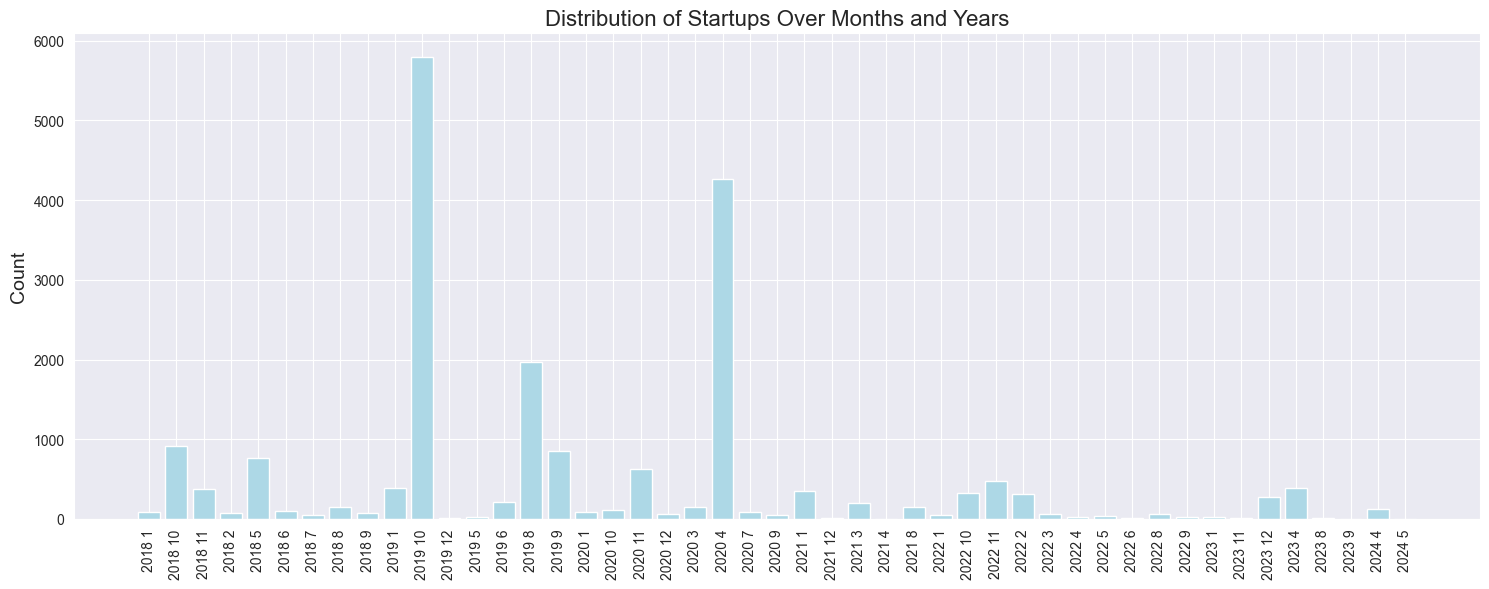

In [12]:
plt.figure(figsize=(15, 6))
plt.bar(startups_per_year.index, startups_per_year.values, width=0.8, color='lightblue')
plt.xlabel('')
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Startups Over Months and Years', fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

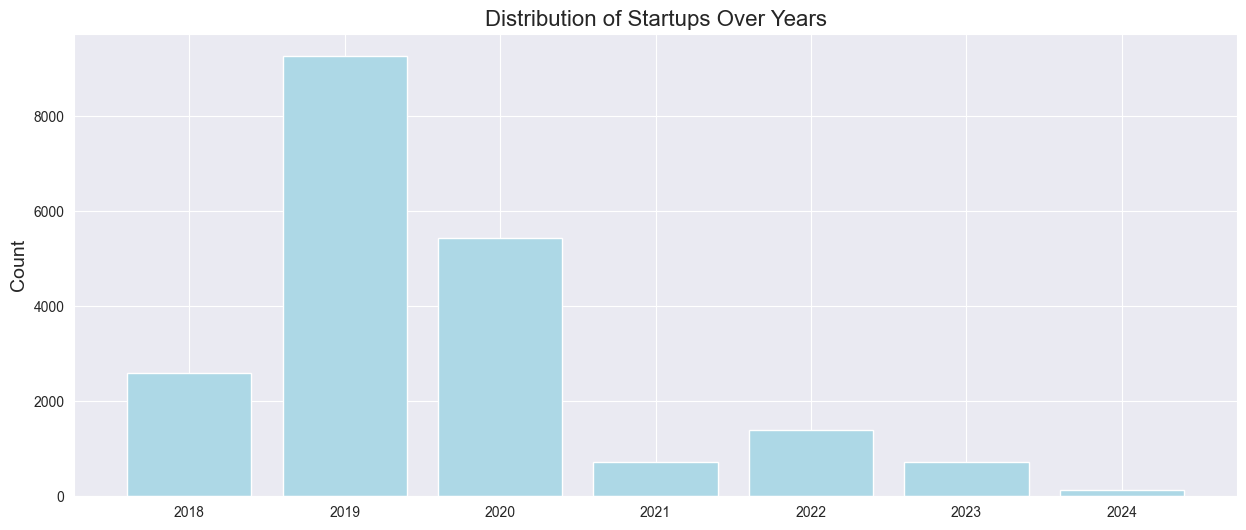

In [13]:
startups_per_year = df.groupby('Start_year').size()
plt.figure(figsize=(15, 6))
plt.bar(x=startups_per_year.index, height=startups_per_year.values, color='lightblue')

plt.xlabel('')
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Startups Over Years', fontsize=16)
plt.show()


## Investigate Breakages

In [14]:
from sqlalchemy import create_engine, text

file = fr"C:\Users\kyle.anderson\pythonProject\msbaCapstone\Capstone\Capstone 3\IWC_Work_Orders_Extract.csv"
df_sql = pd.read_csv(file)
engine = create_engine('sqlite:///:memory:')

df.to_sql('IWC_Work_Orders_Extract', engine, index=False, if_exists='replace')

C:\Users\kyle.anderson\AppData\Local\Temp\ipykernel_31344\2443327464.py:4: DtypeWarning: Columns (8,11,12,13,14,15,16,17,18,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sql = pd.read_csv(file)


20246

### Types of Maintenance
#### What categories of Maintenance are happening and how often?
- Corrective Maintenance Order
- Preventive Maintenance Order
- Administrative Order
- Breakdown Maintenance Order



In [15]:
maint_types = df['MAINTENANCE_TYPE_DESCRIPTION'].value_counts()
maint_types.sort_values(ascending=True,inplace=True)
maint_types.tail(20)

MAINTENANCE_TYPE_DESCRIPTION
Breakdown Maintenance Order         2
Administrative Order             1235
Preventive Maintenance Order     8065
Corrective Maintenance Order    10944
Name: count, dtype: int64

#### Breakdown Maintenance is not recorded often even though stakeholders states otherwise

### Visualize distribution of Maintenance Types

C:\Users\kyle.anderson\AppData\Local\Temp\ipykernel_31344\2965347500.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=maint_types.values, y=maint_types.index, palette='twilight')


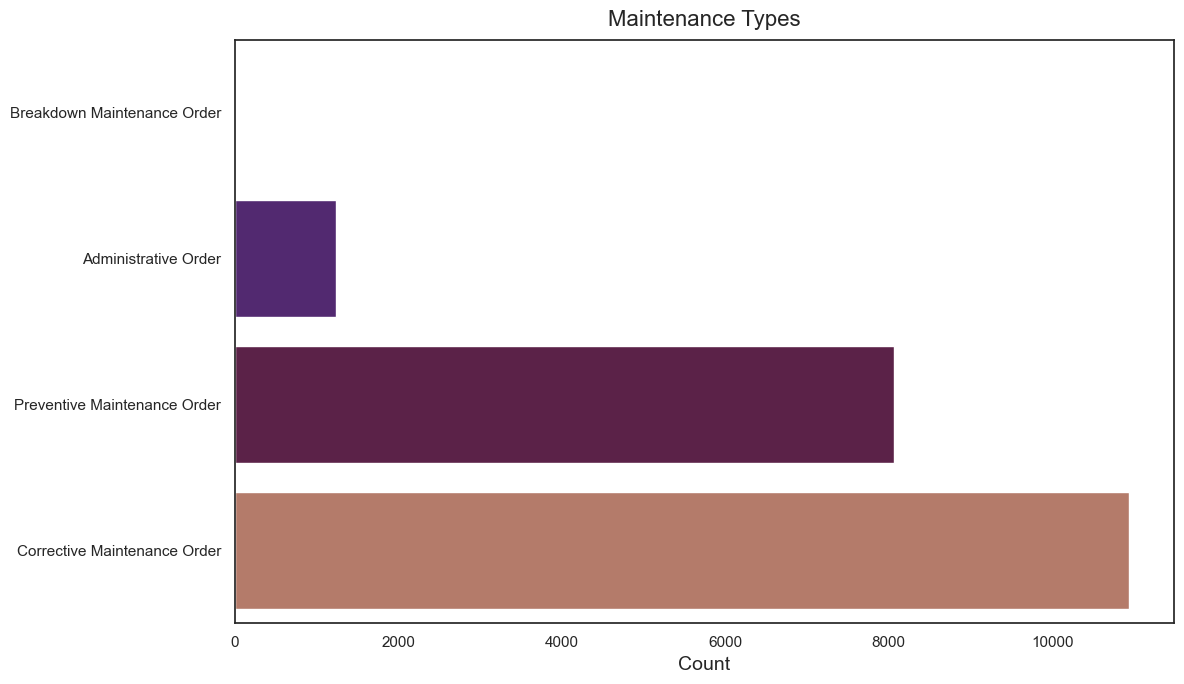

In [16]:
plt.figure(figsize=(12, 7))
sns.set_theme(style="white")

sns.barplot(x=maint_types.values, y=maint_types.index, palette='twilight')

plt.title('Maintenance Types', fontsize=16, pad=10)
plt.xlabel('Count', fontsize=14)
plt.ylabel('', fontsize=14)

plt.tight_layout()
plt.show()

Swire states that breakdowns are affecting their production. However, their records show that breakdowns almost never happen. This is a documentation issue and a case of maintenance being misclassified.

### SQL Alchemy for Grouping

In [17]:
query = text("""
    SELECT EQUIPMENT_DESC, EXECUTION_START_DATE, PRODUCTION_LOCATION, FUNCTIONAL_LOC, COUNT(*) as occurrences
    FROM IWC_Work_Orders_Extract
    WHERE MAINTENANCE_ACTIVITY_TYPE = 'Unplanned'
    GROUP BY EQUIPMENT_DESC, EXECUTION_START_DATE, PRODUCTION_LOCATION, FUNCTIONAL_LOC
    HAVING COUNT(*) > 1
    order by occurrences DESC
""")

In [18]:
# Execute the query
with engine.connect() as connection:
    result = connection.execute(query)

    # Fetch the results and convert to DataFrame
    rows = result.fetchall()
    result_df = pd.DataFrame(rows, columns=result.keys())

# Show the DataFrame with the query results
result_df.head()

,EQUIPMENT_DESC,EXECUTION_START_DATE,PRODUCTION_LOCATION,FUNCTIONAL_LOC,occurrences
0,L1 FILLER_ROTARY_CAN_72_VALVE,2023-08-03 00:00:00.000000,COTA,G816-PRD-L15-L01-L080,13
1,L1 FILLER_ROTARY_CAN_72_VALVE,2023-05-23 00:00:00.000000,COTA,G816-PRD-L15-L01-L080,12
2,L1 FILLER_ROTARY_CAN_72_VALVE,2023-08-18 00:00:00.000000,COTA,G816-PRD-L15-L01-L080,12
3,L1 FILLER_ROTARY_CAN_72_VALVE,2023-02-18 00:00:00.000000,COTA,G816-PRD-L15-L01-L080,10
4,L1 FILLER_ROTARY_CAN_72_VALVE,2023-08-19 00:00:00.000000,COTA,G816-PRD-L15-L01-L080,10


## Production Locations and Unplanned Maintenance

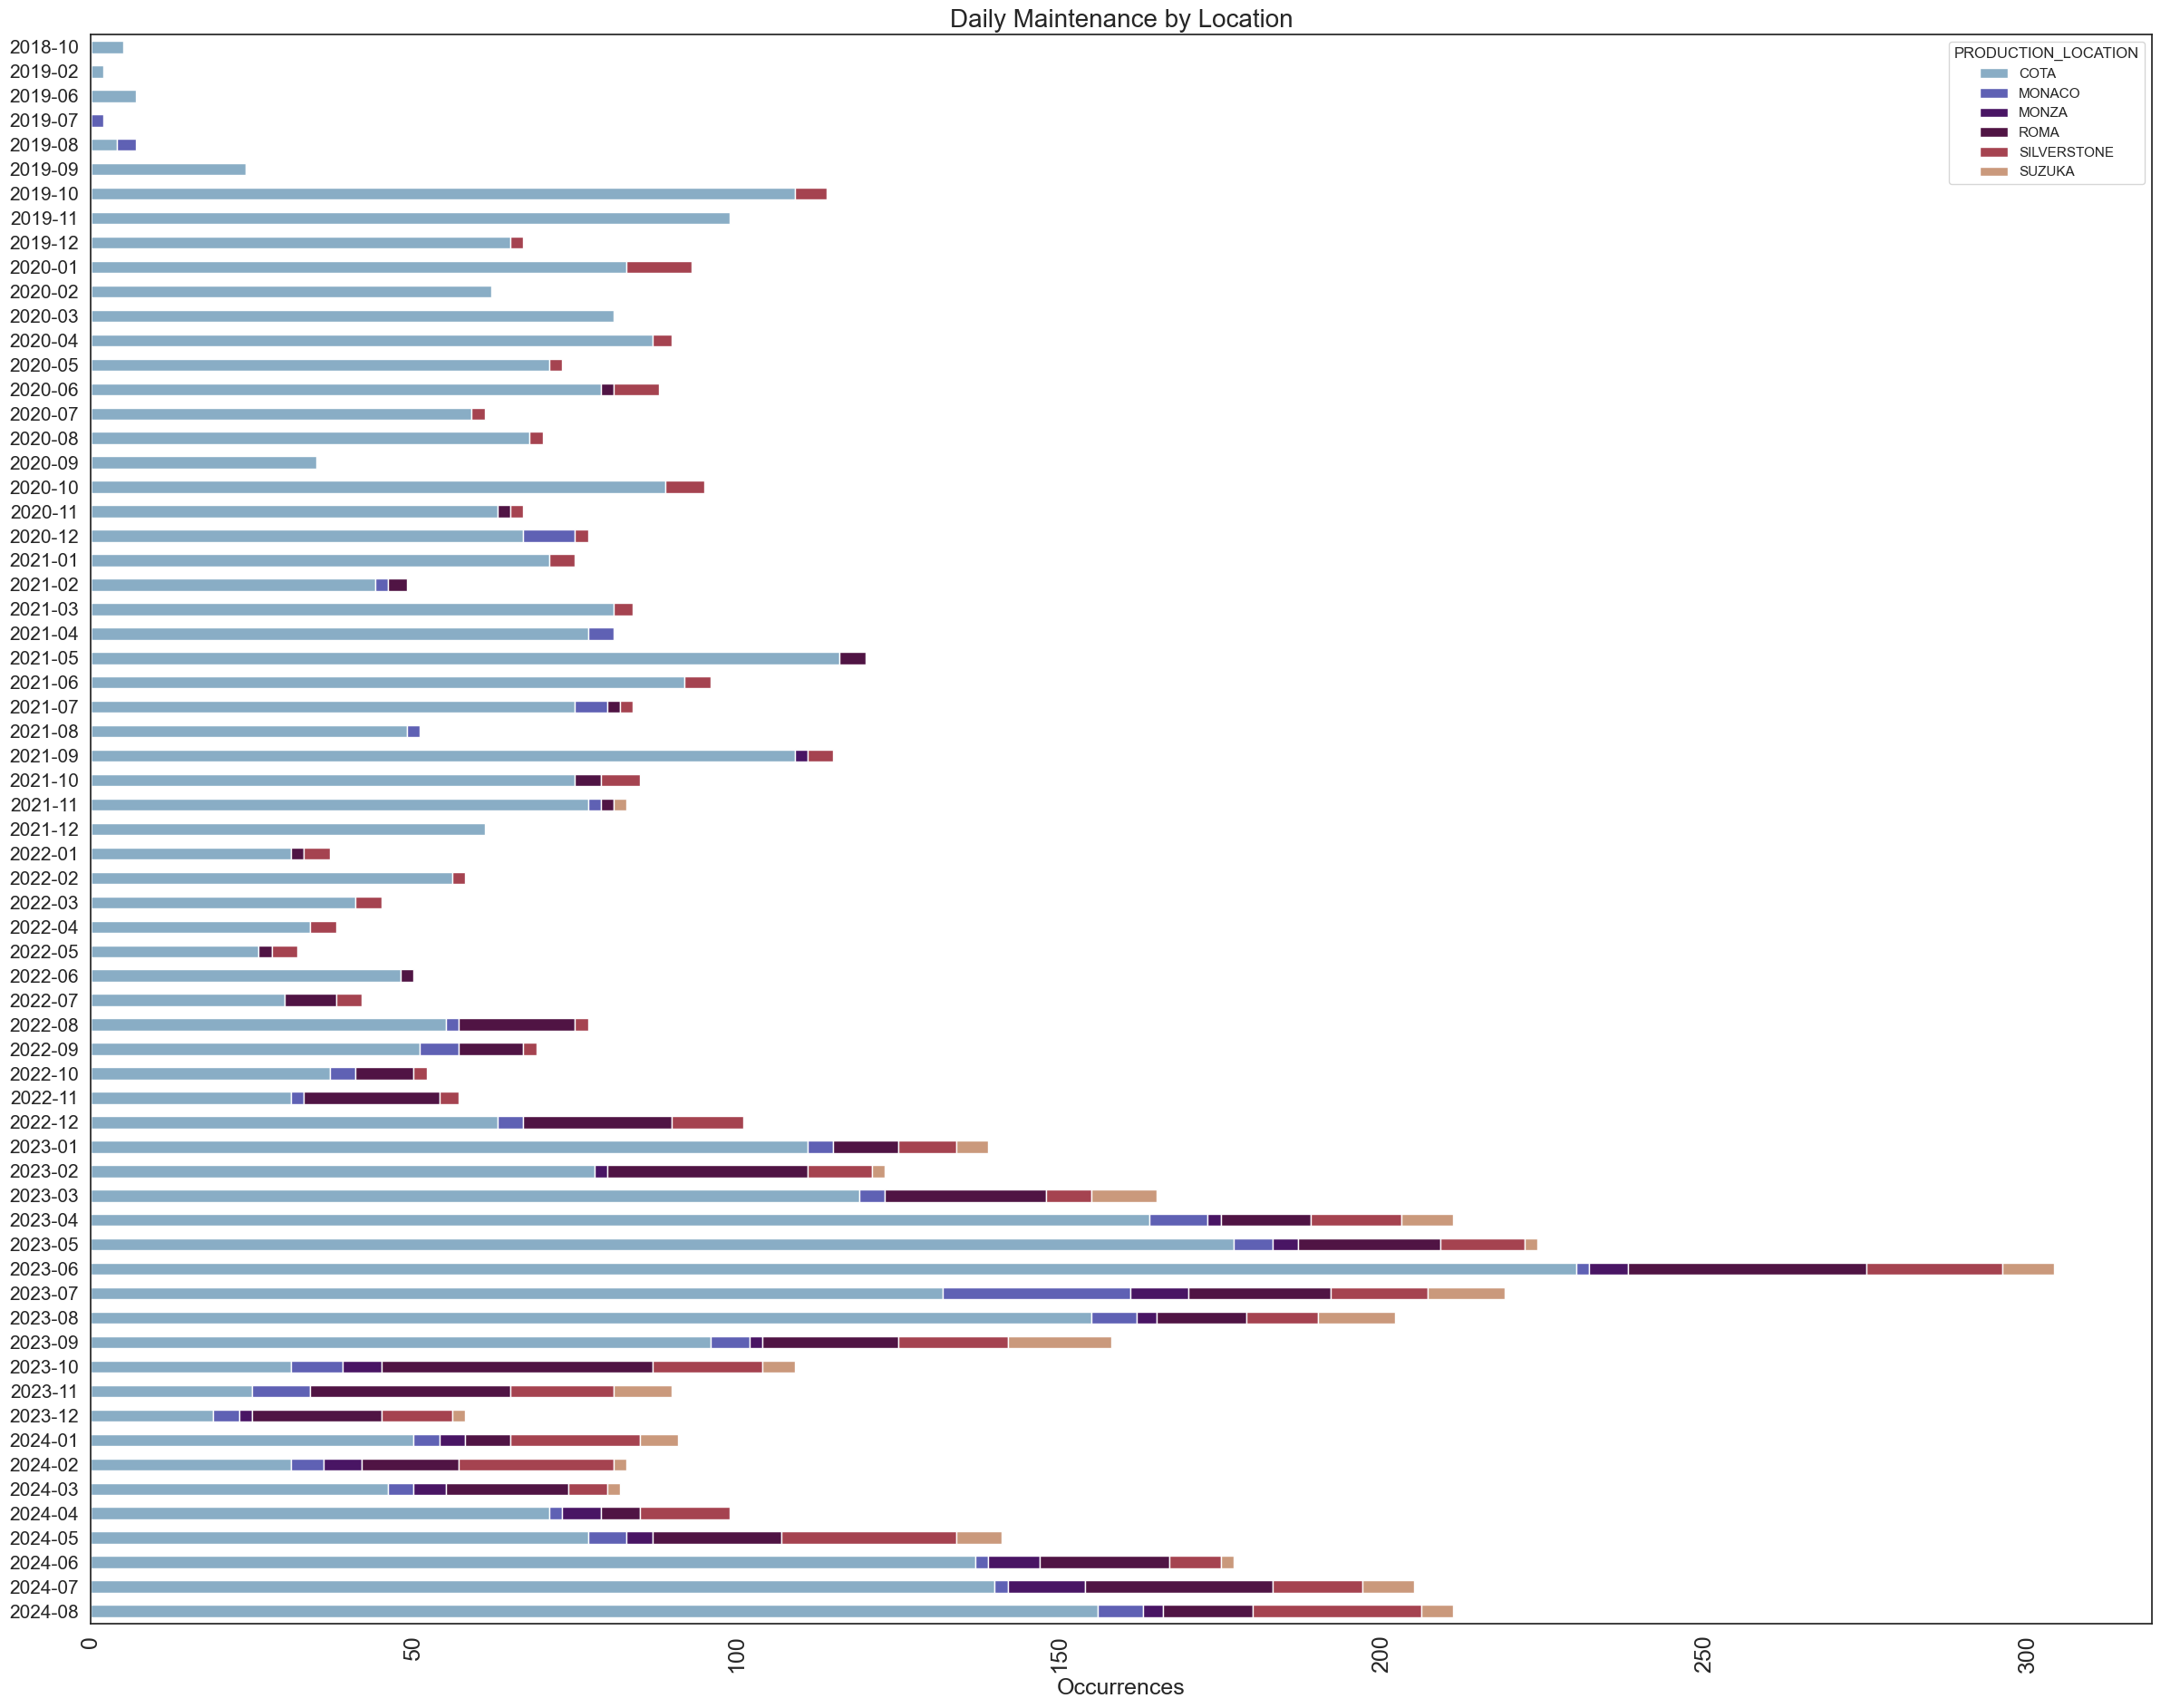

In [19]:
result_df['EXECUTION_START_DATE'] = pd.to_datetime(result_df['EXECUTION_START_DATE'])

result_df['YearMonth'] = result_df['EXECUTION_START_DATE'].dt.to_period('M')
grouped_df = result_df.groupby(['YearMonth', 'PRODUCTION_LOCATION'])['occurrences'].sum().unstack(fill_value=0)
grouped_df.sort_values(by=['YearMonth'], inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(24,19))
grouped_df.plot(kind='barh', stacked=True, ax=ax, color=sns.color_palette("twilight"))

plt.title('Daily Maintenance by Location', fontsize=20)
plt.xticks(rotation=1, size=18)
plt.yticks(size=15)

plt.xlabel('Occurrences', fontsize=18,rotation=0)
plt.ylabel('')
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

So while Silverstone might have more maintenance events in total, COTA appears to have more intensive "cluster" events where the same equipment needs multiple maintenance actions on the same day. This could indicate:

- Different maintenance practices between locations
- Potentially more acute/severe issues at COTA requiring multiple same-day interventions
- Possible differences in how maintenance events are recorded between locations
- Equipment at COTA might be experiencing more catastrophic failures requiring multiple maintenance actions in a single day

#### Questions
- The average number of maintenance events per day for each location
- The distribution of single vs. multiple maintenance events per day
- Whether this pattern is consistent across different types of equipment


## Top Unplanned

In [20]:
query = text("""
    SELECT EQUIPMENT_DESC, FUNCTIONAL_AREA_NODE_2_MODIFIED, PRODUCTION_LOCATION, COUNT(*) as occurrences
    FROM IWC_Work_Orders_Extract
    WHERE MAINTENANCE_ACTIVITY_TYPE = 'Unplanned'
    GROUP BY EQUIPMENT_DESC, PRODUCTION_LOCATION, FUNCTIONAL_AREA_NODE_5_MODIFIED
    HAVING COUNT(*) > 0
    order by occurrences DESC
""")

In [21]:
with engine.connect() as connection:
    result = connection.execute(query)

    # Fetch the results and convert to DataFrame
    rows = result.fetchall()
    result_df = pd.DataFrame(rows, columns=result.keys())

result_df.head()

,EQUIPMENT_DESC,FUNCTIONAL_AREA_NODE_2_MODIFIED,PRODUCTION_LOCATION,occurrences
0,L1 FILLER_ROTARY_CAN_72_VALVE,CAN LINE,COTA,3120
1,L2 LABELER_BOTTLE_TRINE 4600_#1,BOTTLE LINE,COTA,848
2,L1 PACKR_CASE_WESTROCK_DD1250M,CAN LINE,COTA,782
3,L2 LABELER_BOTTLE_TRINE 4600_#2,BOTTLE LINE,COTA,684
4,L2 LINE 2 FILLER,"LINES 1,2,9 - BOTTLE LINES",SILVERSTONE,354


### Top 5 Most Broken Part
### Top 5 Most Unplanned Maintenance for Node 2

COTA 



<Figure size 1000x800 with 0 Axes>

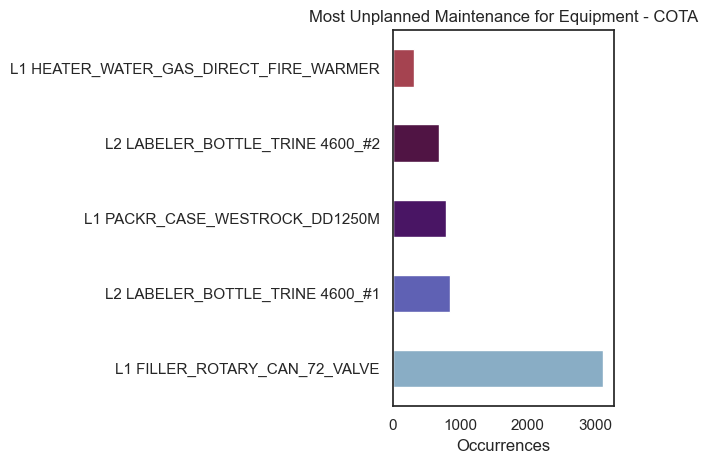

<Figure size 1000x800 with 0 Axes>

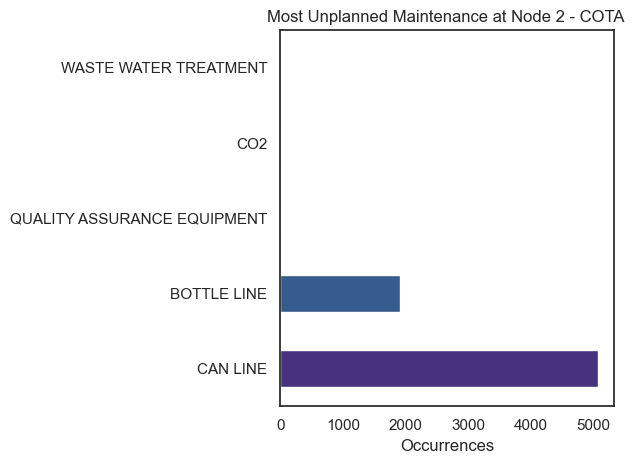

SILVERSTONE 



<Figure size 1000x800 with 0 Axes>

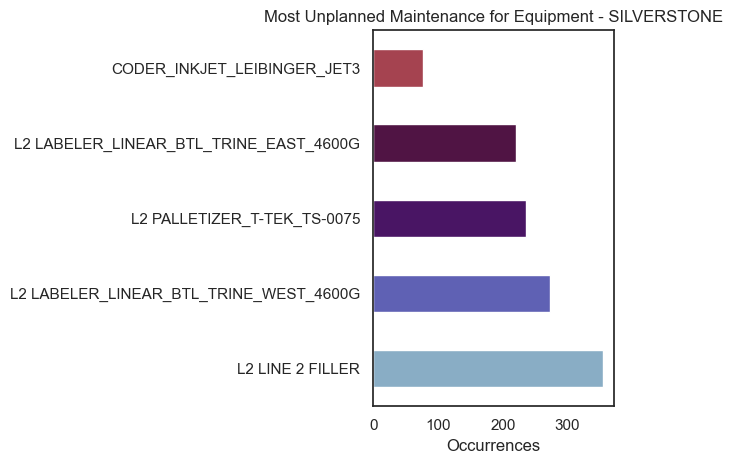

<Figure size 1000x800 with 0 Axes>

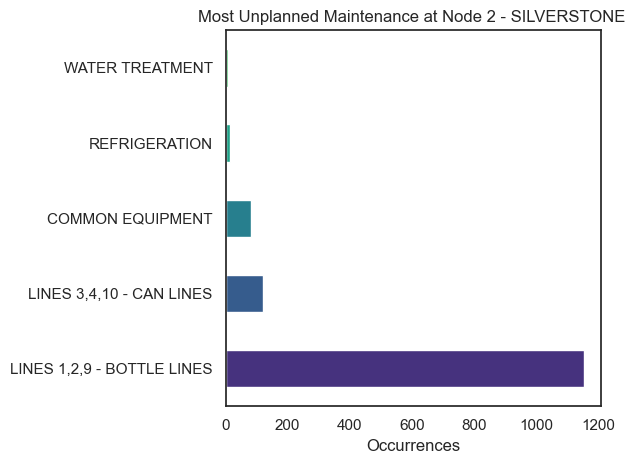

ROMA 



<Figure size 1000x800 with 0 Axes>

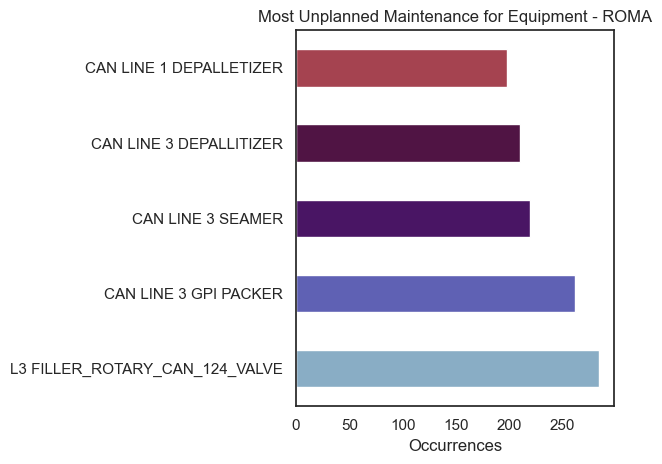

<Figure size 1000x800 with 0 Axes>

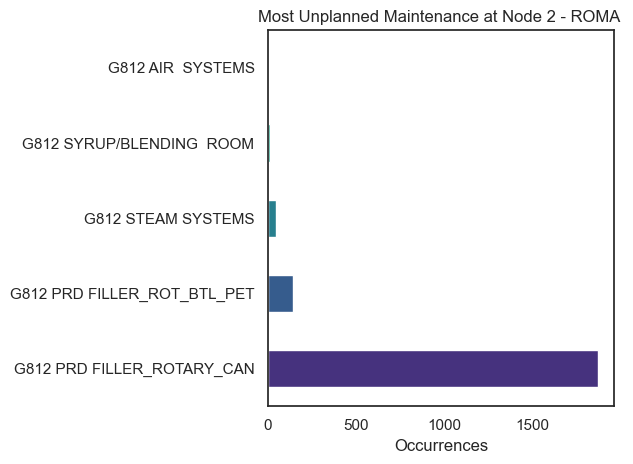

MONZA 



<Figure size 1000x800 with 0 Axes>

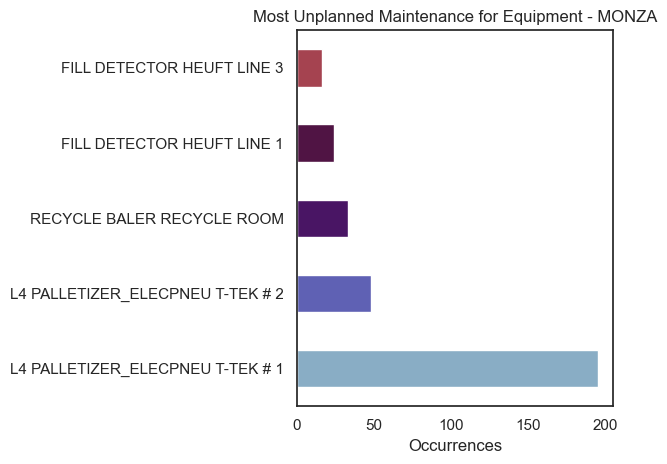

<Figure size 1000x800 with 0 Axes>

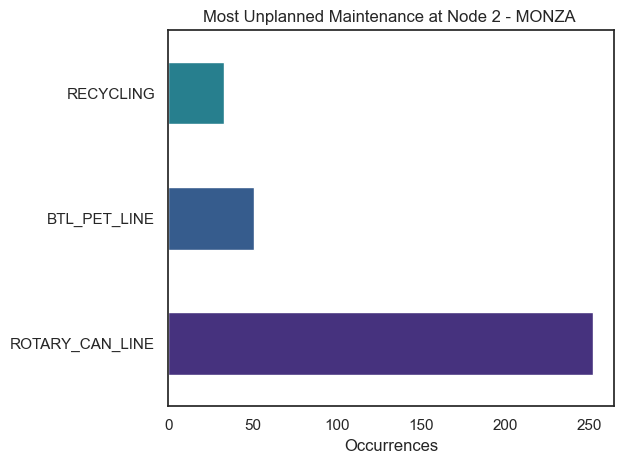

SUZUKA 



<Figure size 1000x800 with 0 Axes>

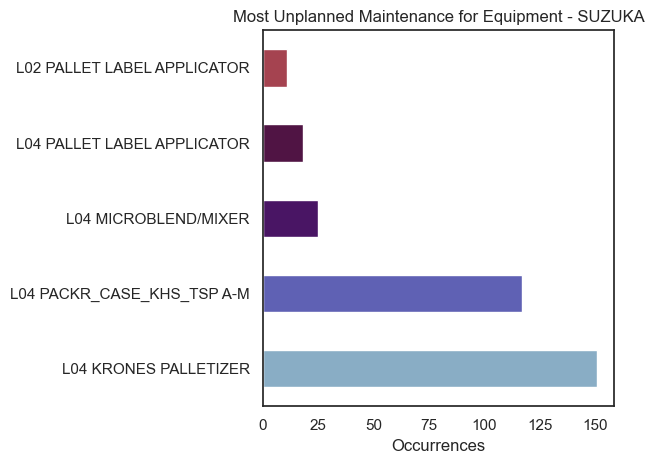

<Figure size 1000x800 with 0 Axes>

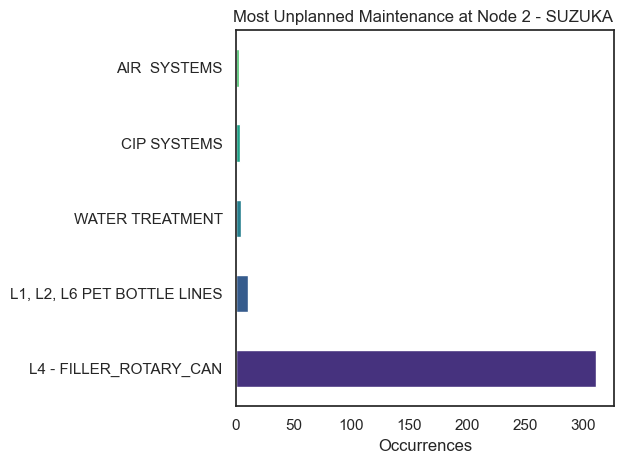

MONACO 



<Figure size 1000x800 with 0 Axes>

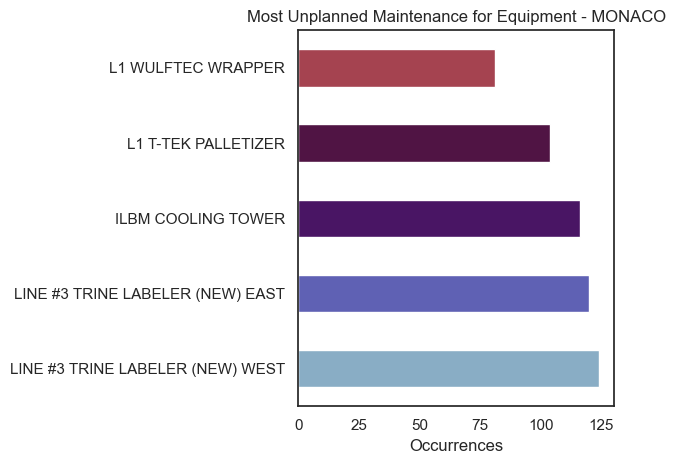

<Figure size 1000x800 with 0 Axes>

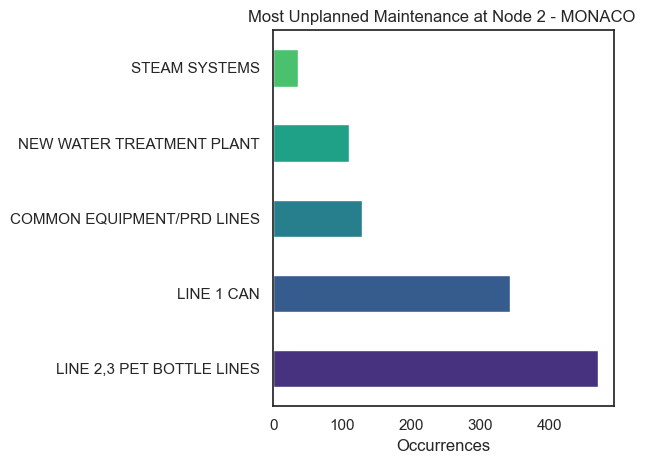

In [22]:
for value in result_df['PRODUCTION_LOCATION'].unique():
    top_5 = result_df[result_df['PRODUCTION_LOCATION'] == value]
    node_5 = top_5.groupby('FUNCTIONAL_AREA_NODE_2_MODIFIED')['occurrences'].sum().reset_index()
    top_5 = top_5.groupby('EQUIPMENT_DESC')['occurrences'].sum().reset_index()
    
    # EQUIPMENT DESC Graphs
    top_5 = top_5.sort_values(by=['occurrences'], ascending=False).head()
    node_5 = node_5.sort_values(by=['occurrences'], ascending=False).head()
    print(value,"\n")
    plt.figure(figsize=(10, 8))
    top_5.plot(kind='barh', x='EQUIPMENT_DESC', y='occurrences', stacked=True, legend=False, color=sns.color_palette("twilight"))
    plt.title(fr"Most Unplanned Maintenance for Equipment - {value}")
    plt.xlabel('Occurrences')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
    
    # NODE Graphs
    plt.figure(figsize=(10, 8))
    node_5.plot(kind='barh', x='FUNCTIONAL_AREA_NODE_2_MODIFIED', y='occurrences', stacked=True, legend=False, color=sns.color_palette("viridis"))
    plt.title(fr"Most Unplanned Maintenance at Node 2 - {value} ")
    plt.xlabel('Occurrences')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
    
    